In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.152
cache size	: 39424 KB
physical id	: 0


In [1]:
!nvidia-smi

Sun Jul 23 10:57:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install MMCV
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0rc1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.8 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 8.1 MB/s eta 0:00:00


In [3]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 15739, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 15739 (delta 30), reused 77 (delta 20), pack-reused 15625
Receiving objects: 100% (15739/15739), 21.38 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (11044/11044), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [4]:
!unzip -qq /content/drive/MyDrive/data_v2.zip

In [5]:
import os
import os.path as osp
import shutil

import cv2
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch, torchvision

import mmcv
import mmseg

In [6]:
print(torch.__version__, torch.cuda.is_available())
print(mmseg.__version__)

2.0.1+cu118 True
1.1.0


In [7]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

# RLE 인코딩 함수
def rle_encode(mask):

    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class BuildingSegDataset(BaseSegDataset):
  METAINFO = dict(
      classes=("bg", "building", "contour"),
      palette=([128, 0, 0], [0, 128, 0], [0, 0, 128])
  )
  def __init__(self,
               img_suffix=".png",
               seg_map_suffix=".png",
               **kwargs):
    super().__init__(
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        **kwargs)

In [9]:
from mmengine import Config
cfg = Config.fromfile('configs/segnext/segnext_mscan-l_1xb16-adamw-160k_ade20k-512x512.py')
# print(f'Config:\n{cfg.pretty_text}')

In [10]:
data_root = "data"
epochs = 30

# cfg.model.backbone.init_cfg.checkpoint = "/content/drive/MyDrive/segnext_large_1024x1024_city_160k.pth"
cfg.model.decode_head.num_classes = 3
# cfg.model.decode_head.out_channels = 1
# cfg.model.decode_head.threshold = 0.45
# cfg.model.decode_head.loss_decode.use_sigmoid = True
# cfg.model.decode_head.loss_decode.loss_name = "loss_bce"



# TODO
# class weight 적용
# DiceLoss, FocalLoss 변경시도해보기
# contour 추가 데이터셋 작성
cfg.model.decode_head.loss_decode = [
    # Focal loss is not supported
    dict(type='CrossEntropyLoss', use_sigmoid=False, class_weight=[0.5, 1.0, 1.0], loss_weight=1.0, loss_name="ce_loss"),
    # dict(type="DiceLoss", loss_weight=2.0),
    dict(type='LovaszLoss', loss_weight=5.0, class_weight=[0.5, 1.0, 1.0], loss_name="lovasz_loss", reduction="none")
]


# Modify dataset type and path
cfg.dataset_type = 'BuildingSegDataset'
cfg.data_root = data_root

# train : 7141 * 0.8 -> 5713
# 5713 / 4 -> 1429 iter == 1 epoch

# cfg.train_cfg.type = "IterBasedTrainLoop"
cfg.train_cfg.max_iters = 1429 * epochs
cfg.train_cfg.val_interval = 1429 * 2

cfg.default_hooks.logger.interval = 200
cfg.default_hooks.checkpoint.interval = 1429
cfg.default_hooks.checkpoint.max_keep_ckpts = 5
# cfg.default_hooks.checkpoint.save_best = True

# cfg.optim_wrapper.type = "AmpOptimWrapper"
# cfg.optim_wrapper.accumulative_counts = 2


crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(
        type='RandomResize',
        scale=(2048, 1024),
        ratio_range=(0.5, 2.0),
        keep_ratio=True
    ),
    dict(type="RandomRotate", prob=0.5, degree=90),
    dict(type='RandomCrop', crop_size=crop_size, cat_max_ratio=0.75),
    dict(type="RandomCutOut", prob=0.5, n_holes=(1, 3), cutout_shape=[(size, size) for size in [50, 75, 100, 125, 150]]),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs'),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=crop_size, keep_ratio=True),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='PackSegInputs'),
]

cfg.train_dataloader.num_workers = 3
cfg.train_dataloader.batch_size = 4
cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.data_prefix = dict(img_path="images/train", seg_map_path="annotations/train")


cfg.val_dataloader.num_workers = 3
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")

cfg.test_dataloader.num_workers = 3
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.data_prefix = dict(img_path="images/val", seg_map_path="annotations/val")


cfg['randomness'] = dict(seed=42)
cfg.work_dir = './work_dirs/segnext'

print(f'Config:\n{cfg.pretty_text}')

Config:
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [
    dict(type='LocalVisBackend'),
]
visualizer = dict(
    type='SegLocalVisualizer',
    vis_backends=[
        dict(type='LocalVisBackend'),
    ],
    name='visualizer')
log_processor = dict(by_epoch=False)
log_level = 'INFO'
load_from = None
resume = False
tta_model = dict(type='SegTTAModel')
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005)
optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(
        type='AdamW', lr=6e-05, betas=(
            0.9,
            0.999,
        ), weight_decay=0.01),
    paramwise_cfg=dict(
        custom_keys=dict(
            pos_block=dict(decay_mult=0.0),
            norm=dict(decay_mult=0.0),
            head=dict(lr_mult=10.0))))
param_scheduler = [
    dict(
        type='LinearLR', start_factor=1e-06, by_epoch=False, beg

In [11]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

07/23 11:13:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 42
    GPU 0: Tesla V100-SXM2-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=comp

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


07/23 11:14:02 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/23 11:14:02 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [12]:
runner.train()

/content/mmsegmentation/mmseg/datasets/transforms/loading.py:83: UserWarning: `reduce_zero_label` will be deprecated, if you would like to ignore the zero label, please set `reduce_zero_label=True` when dataset initialized
  warnings.warn('`reduce_zero_label` will be deprecated, '


07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.weight:lr=6e-05
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.weight:weight_decay=0.0
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.weight:decay_mult=0.0
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.bias:lr=6e-05
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.bias:weight_decay=0.0
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm1.bias:decay_mult=0.0
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.weight:lr=6e-05
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.weight:weight_decay=0.0
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.weight:decay_mult=0.0
07/23 11:14:10 - mmengine - INFO - paramwise_options -- backbone.block1.0.norm2.bias:lr=6e-05
07/23 

Downloading: "https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segnext/mscan_l_20230227-cef260d4.pth" to /root/.cache/torch/hub/checkpoints/mscan_l_20230227-cef260d4.pth


07/23 11:14:56 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias

07/23 11:14:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/23 11:14:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/23 11:14:57 - mmengine - INFO - Checkpoints will be saved to /content/mmsegmentation/work_dirs/segnext.
07/23 11:16:59 - mmengine - INFO - Iter(train) [  200/42870]  base_lr: 7.9654e-06 lr: 7.9654e-06  eta: 7:14:38  time: 0.5540  data_time: 0.0186  memory: 13261  loss: 2.7918  decode.ce_loss: 0.3402  decode.lovasz_loss: 2.4516  decode.acc_seg: 73.8684
07/23 11:18:48 - mmengine - INFO - Iter(train) [  400/42870]  base_lr: 1.5971e-05 lr: 1.5971e-05  eta: 6:49:27  time: 0.5363  data_time: 0.0173  memory: 9155  loss: 2.4248  decode.ce_l

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): MSCAN(
    (patch_embed1): StemConv(
      (proj): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (block1): ModuleList(
      (0): MSCABlock(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (attn): MSCASpatialAttention(
          (proj_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (activation): GELU(approximate='none')
          (spatial_gating_unit): MSCAAttention(
            (conv0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
            (conv0_

In [13]:
!mv work_dirs/segnext/iter_41441.pth /content/drive/MyDrive/segnextv3_iter_41441.pth

In [14]:
!unzip -qq /content/drive/MyDrive/test_img.zip -d data/

In [15]:
submit = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /content/drive/MyDrive/segnextv3_iter_41441.pth
07/23 18:27:30 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


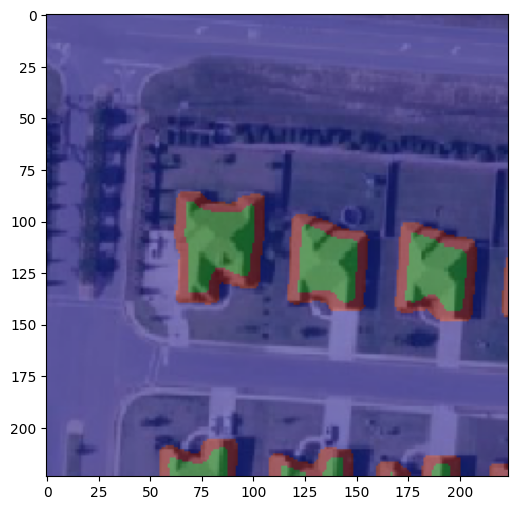

In [16]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/content/drive/MyDrive/segnextv3_iter_41441.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./data/test_img/TEST_00000.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [19]:
mask_lst = []
for idx, row in tqdm(submit.iterrows(), total=len(submit["img_id"])):
  img = mmcv.imread(f"./data/test_img/{row['img_id']}.png")
  result = inference_model(model, img)
  mask = result.pred_sem_seg.data
  mask = mask.detach().cpu().numpy()
  mask[mask==2] = 0
  mask = rle_encode(mask)
  if mask == '':
    mask = -1
  mask_lst.append(mask)
submit["mask_rle"] = mask_lst
submit.to_csv("answer.csv", index=False)

  0%|          | 0/60640 [00:00<?, ?it/s]

In [20]:
!mv answer.csv /content/drive/MyDrive/segnextv2_2to0.csv